In [51]:
%matplotlib inline
import inspect
from numpy import sin, pi, arange
import numpy as np
import matplotlib.pyplot as plt


from scipy.optimize import curve_fit


def my_curve_fit(fit_function, xdata, ydata, p0={}):
    args, _, _, defaults = inspect.getargspec(fit_function)
    defaults = list(defaults)
    for cle, val in p0.items():
        i = args.index(cle)
        defaults[i-1] = val
    popt, _ = curve_fit(fit_function, xdata, ydata, p0=defaults)
    out = dict(zip(args[1:], popt))
    return out

In [60]:
class FitSinus(object):
    _popt = None
    
    def __init__(self, temps, datay, frequence):
        self.temps = temps
        self.datay = datay
        self.frequence_ini = frequence
    
    @staticmethod
    def fit_sinus(x, amplitude=1, offset=0, phase=0, frequence=10):
        return offset + amplitude*sin(2*pi*frequence*x + phase)
    
    def fit(self):
        amplitude = (self.datay.max()-self.datay.min())/2
        offset = (self.datay.max()+self.datay.min())/2
        p0 = {'amplitude': amplitude, 'offset':offset, 'frequence':self.frequence_ini}
        popt = my_curve_fit(self.fit_sinus, self.temps, self.datay, p0=p0)
        if popt['amplitude']<0:
            popt['amplitude'] = -popt['amplitude']
            popt['phase'] += pi
        return popt
    
    @property
    def popt(self):
        if self._popt is None:
            self._popt = self.fit()
        return self._popt
    
    @property
    def phase(self):
        return self.popt['phase']
    
    @property
    def amplitude(self):
        return self.popt['amplitude']

    def plot(self):
        plt.plot(self.temps,self.datay,'o')
        t = np.linspace(self.temps.min(),self.temps.max(),100)
        plt.plot(t,self.fit_sinus(t, **self.popt))
        plt.xlabel("Temps")
        plt.ylabel("Amplitude")
    
#    truc, _, _, machin = inspect.getargspec(fit_sinus)
#    for nom in truc[1:]:
#        locals()[nom] = eval('property(lambda self:self.popt["{nom}"])'.format(nom=nom))
    
#    fit_sinus = staticmethod(fit_sinus)


/dd_int/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if sys.path[0] == '':


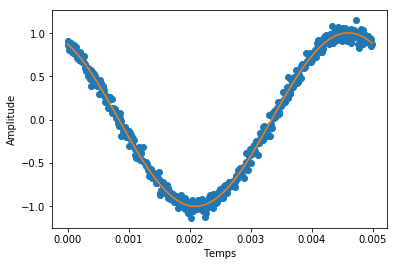

In [62]:
frequence = 200
dt = 1E-5
temps = dt*arange(500)
signal_reference = sin(2*pi*frequence*temps - 4.2)
signal_reference += .05*np.random.normal(size=len(temps))
signal_filtre = .3*np.cos(2*pi*frequence*temps + .2)
signal_filtre += .05*np.random.normal(size=len(temps))

essai = FitSinus(temps, signal_reference, frequence)
#print(essai.fit())
essai.phase
essai.amplitude
essai.plot()

['x', 'amplitude', 'offset', 'phase', 'frequence']

In [72]:
class BodePoint(object):
    def __init__(self, temps, signal_reference, signal_filtre, frequence):
        self.temps = temps
        self.signal_reference = signal_reference
        self.signal_filtre = signal_filtre
        self.frequence = frequence
        self._sinus_filtre = FitSinus(temps, signal_filtre, frequence)
        self._sinus_ref = FitSinus(temps, signal_reference, frequence)
    
    def plot(self):
        plt.subplot(2, 1, 1)
        self._sinus_ref.plot()
        plt.subplot(2, 1, 2)
        self._sinus_filtre.plot()
        
        
    @property
    def gain(self):
        return self._sinus_filtre.amplitude/self._sinus_ref.amplitude
    
    @property
    def dephasage(self):
        return (self._sinus_filtre.phase - self._sinus_ref.phase)%(2*pi)

/dd_int/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if sys.path[0] == '':


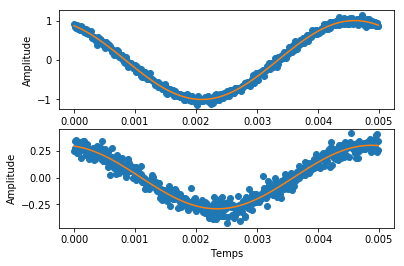

In [73]:
test = BodePoint(temps, signal_reference, signal_filtre, frequence)
test.gain
test.dephasage
test.plot()

In [74]:
class BodeDiagramme(object):
    def __init__(self):
        self.liste_points = []
        
    def ajoute_bode_point(self, bode_point):
        self.liste_points.append(bode_point)
        
    def plot(self):
        plt.subplot(2, 1, 1)
        plt.loglog(self.frequence, self.gain)
        plt.subplot(2, 1, 2)
        plt.semilogx(self.frequence, self.dephasage)
        
    @property
    def frequence(self):
        return [point.frequence for point in self.liste_points]
    
    @property
    def gain(self):
        return [point.gain for point in self.liste_points]
    
    @property
    def dephasage(self):
        return [point.dephasage for point in self.liste_points]

/dd_int/anaconda3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if sys.path[0] == '':
/dd_int/anaconda3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


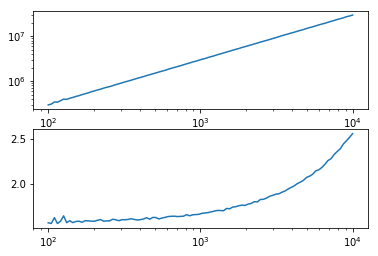

In [80]:
test = BodeDiagramme()
for frequence in np.logspace(2,4,100):
    dt = 1E-5
    temps = dt*arange(500)
    signal_reference = sin(2*pi*frequence*temps)
    signal_reference += .05*np.random.normal(size=len(temps))
    signal_filtre = .3*frequence*10000*np.cos(2*pi*frequence*temps + frequence/10000)
    signal_filtre += .05*np.random.normal(size=len(temps))
    test.ajoute_bode_point(BodePoint(temps, signal_reference, signal_filtre, frequence))
test.plot()